## Introduction

Inflation plays a key role in shaping various aspects of the economy, from interest rates and consumer spending to investment decisions and public policy. However, predicting inflation accurately remains a significant challenge due to the complexity and unpredictability of the economic factors at play. This project aims to tackle that challenge by developing a machine learning model that can forecast the U.S. inflation rate and Consumer Price Index (CPI) for up to six months in advance. With precise and timely inflation predictions, the model will empower decision-makers, including Federal Reserve policymakers, financial analysts, corporate finance teams, government agencies, and consumers, to respond proactively to inflationary trends and make better-informed decisions on matters like interest rates, budgeting, and risk management.

The goal of the project is not just to deliver reliable short-term CPI and inflation forecasts but also to uncover valuable insights into the economic forces driving inflation. Traditional models often miss the complex, non-linear relationships between variables, which is why machine learning is an ideal approach for this task. By tapping into over 25 years of historical economic data from the Federal Reserve Economic Data (FRED) platform, covering variables such as M2 Money Supply, 10-Year Treasury Yield, and Federal Funds Rate, the project uses machine learning techniques to identify patterns that enhance forecasting accuracy.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from collections import deque
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('macro_data_monthly.csv', parse_dates=['Date'], index_col='Date')

The original dataset was compiled from various Federal Reserve sources and provided in daily format. However, it was resampled to monthly frequency since most key macroeconomic indicators, such as CPI, Fed Funds Rate, GDP, Sticky Inflation, M2 Money Supply, Unemployment Rate, and Inflation—are officially published on a monthly basis.

For the 10-Year Treasury Yield, which is available daily, we selected the month-end value to maintain alignment with the rest of the dataset. This monthly resampling ensures a consistent time scale across all features, which is crucial for accurate modeling and analysis.

### Exploratory Data Analysis

In [3]:
# Display basic info
print("Data Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 534 entries, 1981-01-31 to 2025-06-30
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   10Y_Treasury_Yield  534 non-null    float64
 1   CPI                 534 non-null    float64
 2   Fed_Funds_Rate      534 non-null    float64
 3   GDP                 534 non-null    float64
 4   Inflation_Sticky    534 non-null    float64
 5   M2_Money_Supply     534 non-null    float64
 6   Unemployment Rate   534 non-null    float64
 7   Inflation           534 non-null    float64
dtypes: float64(8)
memory usage: 37.5 KB
None

Summary Statistics:
       10Y_Treasury_Yield         CPI  Fed_Funds_Rate           GDP  \
count          534.000000  534.000000      534.000000    534.000000   
mean             5.498258  188.120288        4.222528  12671.629736   
std              3.234940   60.868958        3.707838   7179.378796   
min              0.550000

In [4]:
data.head()

,10Y_Treasury_Yield,CPI,Fed_Funds_Rate,GDP,Inflation_Sticky,M2_Money_Supply,Unemployment Rate,Inflation
Date,,,,,,,,
1981-01-31,12.68,87.2,19.08,3124.206,12.018101,1599.8,7.5,12.35
1981-02-28,13.43,88.0,15.93,3124.206,11.229271,1609.0,7.4,11.79
1981-03-31,13.13,88.6,14.70,3124.206,10.319341,1637.5,7.4,10.61
1981-04-30,14.11,89.1,15.72,3162.532,9.710597,1657.1,7.2,10.14
1981-05-31,13.50,89.7,18.52,3162.532,9.603161,1648.4,7.5,10.14


In [5]:
# Convert Fed Funds Rate (%) to a multiplicative factor (e.g., 5% -> 1.05) for model input
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1


In [6]:
# Convert 10-Year Treasury Yield (%) to a multiplicative factor (e.g., 4% -> 1.04) for consistency with other financial features
data['10Y_Treasury_Yield'] = (data['10Y_Treasury_Yield'] / 100) + 1


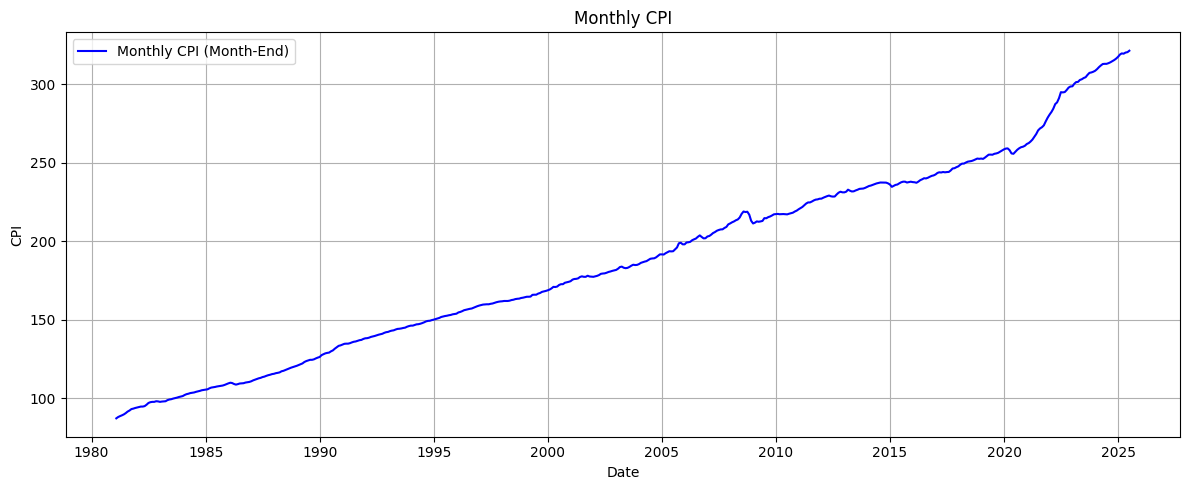

In [7]:
# CPI data to month-end frequency
monthly_cpi = data['CPI'].resample('ME').last()

# Plot monthly CPI values
plt.figure(figsize=(12, 5))  # Set the plot size
sns.lineplot(x=monthly_cpi.index, y=monthly_cpi.values, label='Monthly CPI (Month-End)', color='blue')  # Line plot of CPI
plt.title('Monthly CPI')  
plt.xlabel('Date')  
plt.ylabel('CPI')  
plt.grid(True)  #
plt.tight_layout()  
plt.show()  

Since 2020, CPI has surged noticeably, largely due to the economic fallout from the COVID-19 pandemic. In response to the crisis, the U.S. government and Federal Reserve rolled out massive stimulus measures and slashed interest rates, injecting significant liquidity into the economy. While these actions helped stabilize demand, supply chain disruptions and labor shortages created bottlenecks, pushing prices higher. The result was a sharp and sustained increase in inflation, clearly visible in the post-2020 CPI trend.

In [8]:
# Calculate monthly rate of change (as %)
data['CPI_Rate_Change'] = data['CPI'].pct_change() * 100

# Drop the first row if needed (because of NaN from pct_change)
data = data.dropna(subset=['CPI_Rate_Change'])


C:\Users\steve\AppData\Local\Temp\ipykernel_26380\2016439849.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


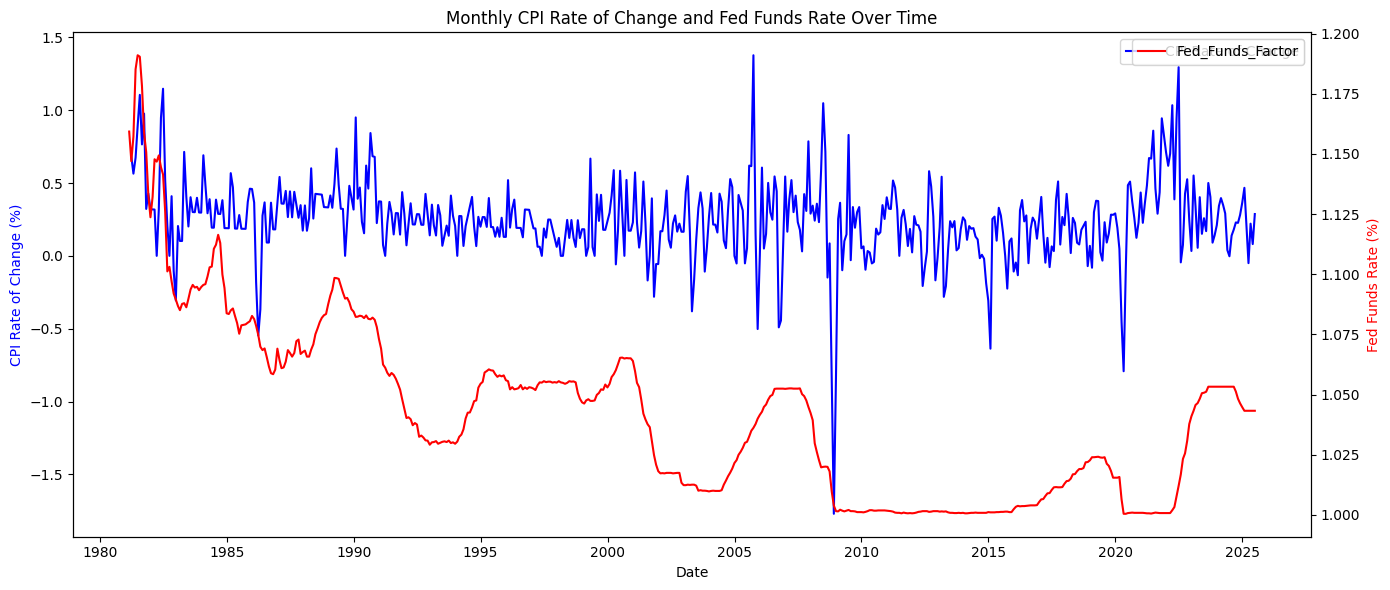

In [9]:
# Resample to monthly average
monthly_data = data.resample('M').mean()

# Calculate month-to-month CPI rate of change (%)
monthly_data['CPI_Rate_Change'] = monthly_data['CPI'].pct_change() * 100

# Create the plot
plt.figure(figsize=(14, 6))

# Plot CPI Rate of Change
ax1 = sns.lineplot(x=monthly_data.index, y=monthly_data['CPI_Rate_Change'], color='blue', label='CPI Rate of Change')
ax1.set_ylabel('CPI Rate of Change (%)', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=monthly_data.index, y=monthly_data['Fed_Funds_Factor'], color='red', ax=ax2, label='Fed_Funds_Factor')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('Monthly CPI Rate of Change and Fed Funds Rate Over Time')
plt.tight_layout()
plt.show()

This chart shows that changes in the Fed Funds Factor (red) tend to lag behind movements in the CPI rate of change (blue), meaning the Fed often responds to inflation after it has already started rising. For instance, after the post-2020 spike in CPI, interest rates were only raised months later. Historically, we also see that the Fed’s response to inflation, like in the 1980s and the COVID era is often gradual, likely to avoid economic shock. Overall, this suggests that interest rate policy effects on inflation are delayed, making lag variables essential for forecasting CPI accurately.

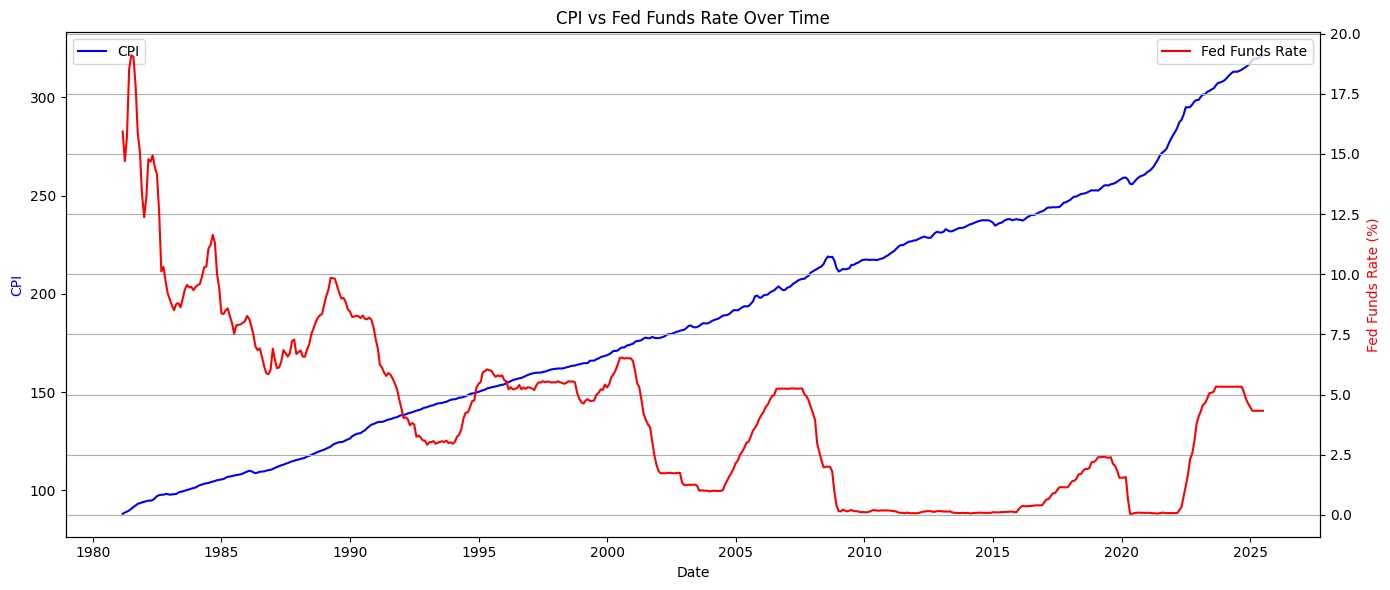

In [10]:
# Plot CPI and Fed Funds Rate
plt.figure(figsize=(14, 6))

# Plot CPI
ax1 = sns.lineplot(x=data.index, y=data['CPI'], color='blue', label='CPI')
ax1.set_ylabel('CPI', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=data.index, y=data['Fed_Funds_Rate'], color='red', ax=ax2, label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('CPI vs Fed Funds Rate Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

This chart compares the Consumer Price Index (CPI) with the Fed Funds Rate over time, showing that while CPI (blue line) has steadily climbed for decades, the Fed Funds Rate (red line) has moved more cyclically in response to economic conditions. Notably, CPI continued rising through long periods of low interest rates, especially from 2010 to 2020, and only surged sharply after 2020. The Fed responded by rapidly raising rates, but the lag highlights how monetary policy often trails inflation trends. Overall, the graph illustrates that inflation builds gradually, while interest rate adjustments are reactive and episodic.

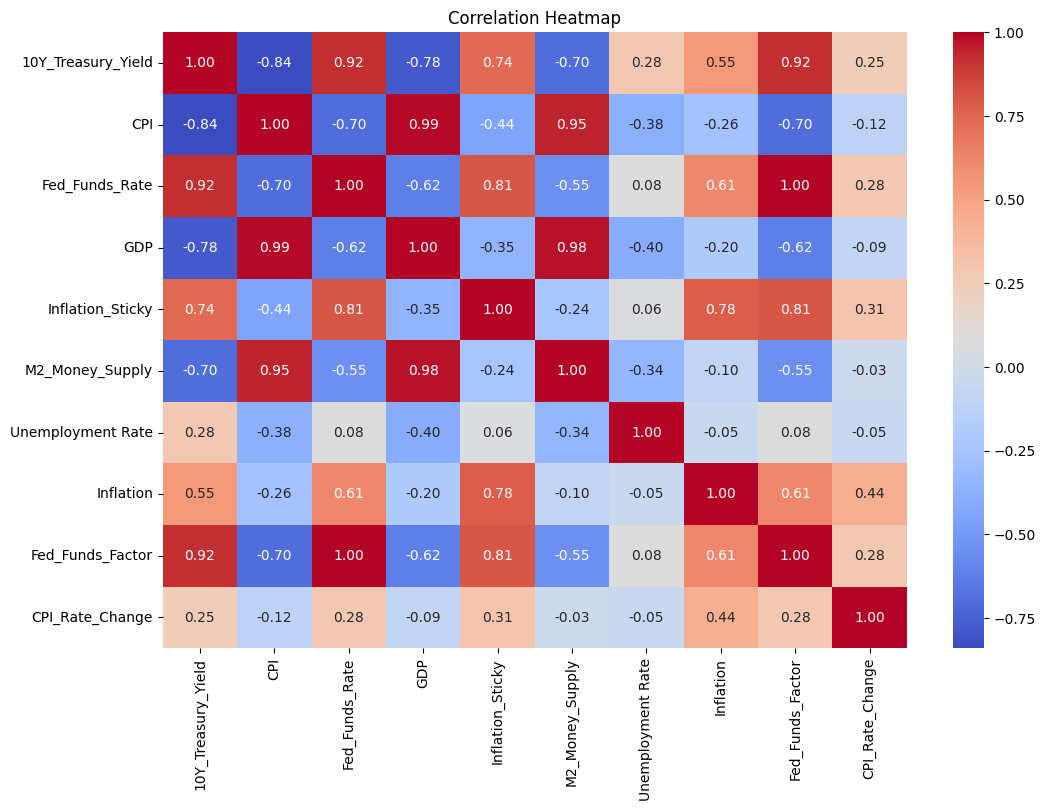

In [11]:
# Correlation heatmap (for numeric columns)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The heatmap reveals that CPI is strongly positively correlated with GDP (0.99) and M2 Money Supply (0.95), suggesting that as the economy grows and liquidity increases, consumer prices tend to rise. This supports the classic macroeconomic view that inflation is partly demand-driven and influenced by the volume of money circulating in the economy. CPI also has a moderately strong correlation with sticky inflation (0.78), indicating that persistent, slower-moving components of inflation tend to mirror broader price levels over time.

On the flip side, CPI shows a strong negative correlation with the 10-year Treasury Yield (-0.84) and a moderate negative correlation with both the Fed Funds Rate and its factor (-0.70). This suggests that interest rates often respond to inflation rather than drive it preemptively—highlighting the Fed’s tendency to act reactively. These inverse relationships also imply a delayed impact of rate hikes on inflation, underscoring the importance of including lagged variables when building forecasting models for CPI.

---
### Model Performance Evaluation

In this section, we evaluate the predictive performance of four models - **Linear Regression**, **Ridge Regression**, **Random Forest**, and **XGBoost** across forecast horizons ranging from 1 to 12 months.

We start by calculating the annualized CPI rate of change and derive the **real interest rate** by subtracting CPI growth from the Fed Funds Rate. We then generate lag features to capture historical influence on future CPI values. For each forecast horizon, we create a target variable (CPI shifted by horizon months into the future), split the data into training and testing sets, and fit each model using the same feature set.

Each model is evaluated using **R²** and **Mean Squared Error (MSE)**. The final result is a line chart comparing R² scores across all models and forecast horizons, helping us visualize how each model's performance changes as we try to predict further into the future.


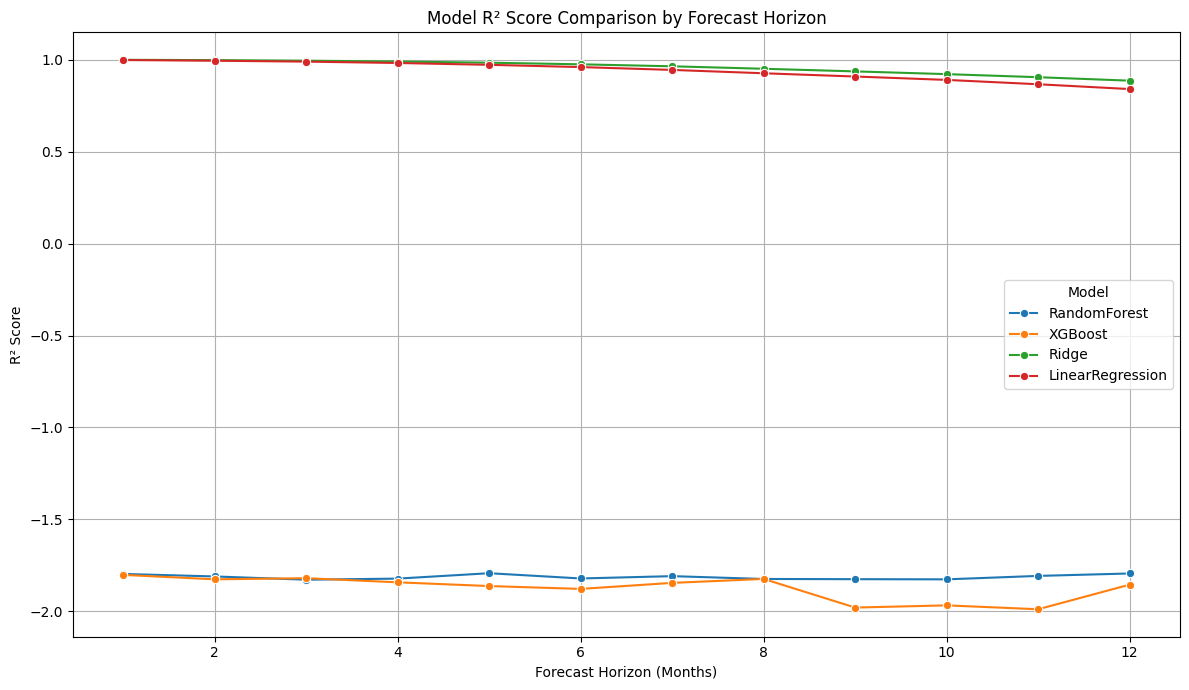

In [12]:
# Filter for rows with CPI values
data = data[data['CPI'].notna()]

# Step 1: Calculate CPI rate of change (annualized)
data['CPI_Rate'] = data['CPI'].pct_change(periods=1) * 12 * 100

# Step 2: Define Real Interest Rate
data['Real_Fed_Funds_Rate'] = data['Fed_Funds_Rate'] - data['CPI_Rate']
data['CPI_change'] = data['CPI'].pct_change(periods=1) * 100

# Step 3: Feature engineering with lags
data['CPI_lag1'] = data['CPI'].shift(1)
data['CPI_lag2'] = data['CPI'].shift(2)
data['Fed_Funds_Rate_lag1'] = data['Fed_Funds_Rate'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['Unemployment_lag1'] = data['Unemployment Rate'].shift(1)

# Drop rows with NaNs after lagging
data = data.dropna()

# Define features used in modeling
feature_cols = [
    'CPI_lag1', 'CPI_lag2',
    'Fed_Funds_Rate_lag1',
    'M2_lag1',
    'Unemployment_lag1',
    'Real_Fed_Funds_Rate'
]

# Define models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression())
}

# Store results
results = []

# Loop over forecast horizons
for horizon in range(1, 13):
    target_col = f'CPI_t_plus_{horizon}'
    data[target_col] = data['CPI'].shift(-horizon)

    df = data[feature_cols + [target_col]].dropna()
    X = df[feature_cols]
    y = df[target_col]

    split_idx = int(len(df) * 0.8)  
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Horizon": horizon,
            "Model": model_name,
            "MSE": round(mse, 2),
            "R2": round(r2, 4)
        })

# Compile results into DataFrame
comparison_df = pd.DataFrame(results)

# Plot R² score comparison
plt.figure(figsize=(12, 7))
sns.lineplot(data=comparison_df, x="Horizon", y="R2", hue="Model", marker="o")
plt.title("Model R² Score Comparison by Forecast Horizon")
plt.ylabel("R² Score")
plt.xlabel("Forecast Horizon (Months)")
plt.grid(True)
plt.tight_layout()
plt.show()

The chart shows how well different models predict future CPI values over various forecast horizons, measured by their R² scores. LinearRegression and Ridge perform the best, maintaining high R² values close to 1.0 across all 12 months, indicating strong predictive power and stability. In contrast, RandomForest and XGBoost significantly underperform, with consistently negative R² scores, suggesting they fail to generalize and are possibly overfitting to noise. As the forecast horizon increases, the performance of all models slightly declines, which is expected due to growing uncertainty. Overall, simpler linear models like Ridge and LinearRegression appear better suited for CPI forecasting in this setup.

---
### Linear Regression
We start with Linear Regression as a simple and interpretable model to establish a baseline for CPI forecasting. It helps us understand how each macroeconomic feature, such as interest rates, money supply, and Treasury yields which contributes to predicting future CPI values.

To evaluate the model realistically, we use TimeSeriesSplit for cross-validation. Unlike random train-test splits, this method respects the chronological order of data, ensuring that each fold only trains on the past and tests on the future. This setup better reflects how the model would perform in real-world forecasting scenarios and provides a more honest assessment of its predictive accuracy.

In [32]:
# --- Ensure valid CPI data ---
data = data[data['CPI'].notna()]

# --- Lag Feature Engineering ---
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1
data['CPI_lag1'] = data['CPI'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['FedFundsFactor_lag3'] = data['Fed_Funds_Factor'].shift(3)
data['FedFundsFactor_lag6'] = data['Fed_Funds_Factor'].shift(6)
data['CPI_1mo_ahead'] = data['CPI'].shift(-1)

# --- Feature Set ---
features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'FedFundsFactor_lag3',
    'FedFundsFactor_lag6',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# --- Prepare Data ---
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']

# --- Model Pipeline ---
model_1mo = make_pipeline(StandardScaler(), LinearRegression())

# --- TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=3)

# --- Cross-Validation Scores ---
mse_scores = -cross_val_score(model_1mo, X, y, cv=tscv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model_1mo, X, y, cv=tscv, scoring='r2')

# --- Print Evaluation ---
print("Mean MSE across folds:", np.mean(mse_scores))
print("Mean R² across folds:", np.mean(r2_scores))

Mean MSE across folds: 1.3875598468180754
Mean R² across folds: 0.9950576636055869


In [33]:
# --- Fit the pipeline on training data ---
model_1mo.fit(X_train, y_train)

# --- Model Evaluation ---
y_pred = model_1mo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("1-Month Ahead CPI Forecast - Evaluation:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")

1-Month Ahead CPI Forecast - Evaluation:
Mean Squared Error: 2.780
R² Score: 0.9961


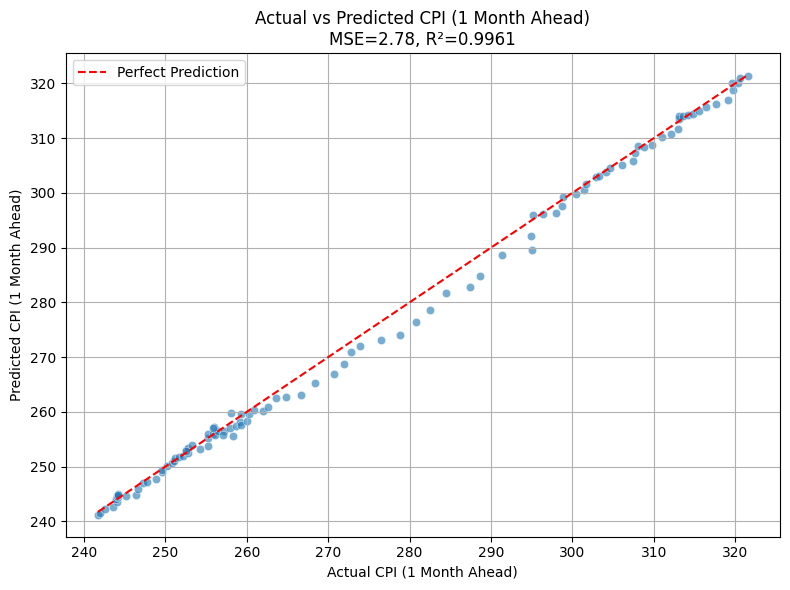

In [34]:
# --- 5. Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual CPI (1 Month Ahead)")
plt.ylabel("Predicted CPI (1 Month Ahead)")
plt.title(f"Actual vs Predicted CPI (1 Month Ahead)\nMSE={mse:.2f}, R²={r2:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows how well our linear regression model predicted the Consumer Price Index (CPI) one month ahead. The closer the blue dots are to the red dashed line (representing perfect predictions), the better the model performed. Most predictions fall very close to this line, though there's a slight deviation between CPI values of 260 and 290. Still, with an R² score of 0.9961 and a mean squared error of just 2.78, the model demonstrates excellent accuracy in capturing short-term inflation trends.

What’s more, the model held up well under time series cross-validation. The average R² across splits was 0.9951, and the mean squared error remained low at 1.39. These results show that even a straightforward linear regression—when paired with well-engineered lag features and time-aware validation, can provide a solid foundation for forecasting near-term CPI. It serves as a reliable baseline as we move on to explore more sophisticated models.

C:\Users\steve\AppData\Local\Temp\ipykernel_26380\405209901.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_26380\405209901.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_26380\405209901.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


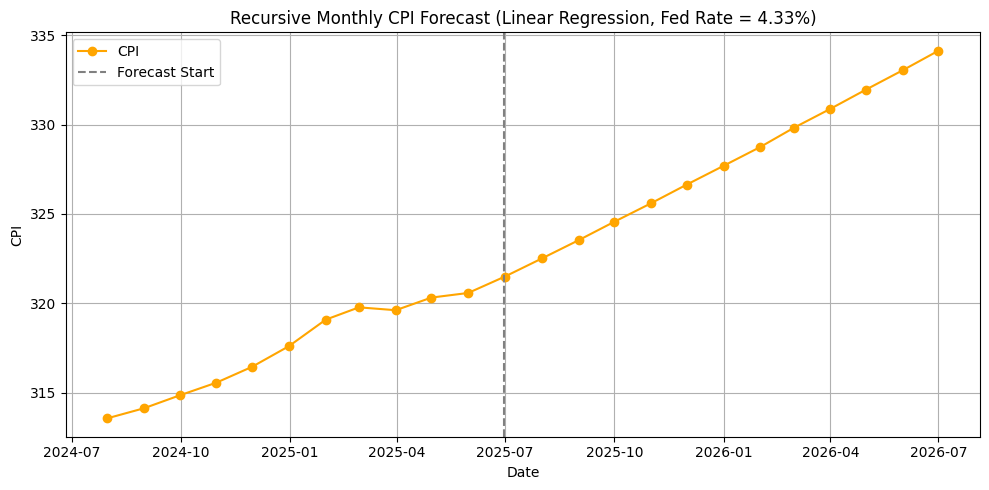


Forecast Table (Linear Regression, Fed Rate = 4.33%)
         Date  Forecasted CPI
0  2025-07-01      321.500000
1  2025-08-01      322.508415
2  2025-09-01      323.531480
3  2025-10-01      324.561119
4  2025-11-01      325.597373
5  2025-12-01      326.640285
6  2026-01-01      327.689898
7  2026-02-01      328.746254
8  2026-03-01      329.809398
9  2026-04-01      330.879372
10 2026-05-01      331.956220
11 2026-06-01      333.039988
12 2026-07-01      334.130718


In [35]:
# --- Forecast Setup ---
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=13, freq='MS')  # +1 month
forecast_cpi = [initial_cpi]  # Start forecast with last historical CPI

# --- Initialize lag buffer for Fed Funds Factor ---
fed_factor_history = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)
cpi_lag1 = initial_cpi
m2_lag1 = m2

# --- Forecast Logic (recursive for 12 future months) ---
for _ in range(12):  # previously 11
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor_history[-1],
        'FedFundsFactor_lag1': fed_factor_history[-2],
        'FedFundsFactor_lag3': fed_factor_history[-4],
        'FedFundsFactor_lag6': fed_factor_history[-7],
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1
    }])

    pred_cpi = model_1mo.predict(input_df)[0]
    forecast_cpi.append(pred_cpi)

    # update lags
    fed_factor_history.append(fed_factor)
    cpi_lag1 = pred_cpi
    m2_lag1 = m2

# --- Plotting ---
combined_dates = past_cpi.index[:-1].append(forecast_dates)
combined_cpi = past_cpi.tolist()[:-1] + forecast_cpi 

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', color='orange', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Linear Regression, Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted CPI': forecast_cpi  # includes starting CPI + 12 predicted
})
print("\nForecast Table (Linear Regression, Fed Rate = 4.33%)")
print(forecast_table)


This forecast uses a linear regression model with time series cross-validation to predict CPI for the next 12 months, beginning from the most recent data point. The model operates recursively, each predicted month's CPI is used as an input for the next month's forecast, alongside macroeconomic features like the Fed Funds Rate (held constant at 4.33%), M2 money supply, and lagged CPI values.

The resulting forecast shows a steady and consistent upward trend in CPI, with each month adding around one index point. While the trajectory appears smoother than historical patterns, the steady climb suggests that the model is capturing the inflation momentum currently embedded in the macro environment. The use of lag features combined with recursive forecasting may be amplifying this trend slightly, projecting a persistent but controlled inflation path if present conditions continue.

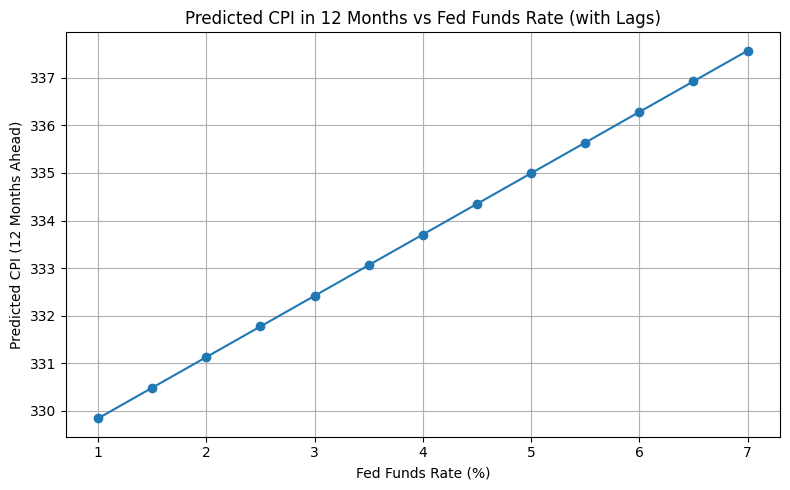


Forecast Table:
 Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)
                1.0                       329.845587
                1.5                       330.489000
                2.0                       331.132413
                2.5                       331.775826
                3.0                       332.419239
                3.5                       333.062652
                4.0                       333.706065
                4.5                       334.349479
                5.0                       334.992892
                5.5                       335.636305
                6.0                       336.279718
                6.5                       336.923131
                7.0                       337.566544


In [36]:
# --- Setup for Simulation ---
rates = np.arange(1.0, 7.1, 0.5)  # Fed Funds Rate from 1.0% to 7.0%
forecast_horizon = 12  # months ahead

# Latest known values
initial_cpi = data['CPI'].dropna().iloc[-1]
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Get last 7 months of Fed_Funds_Factor history
fed_factor_history_full = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)

# Store final CPI forecasts
predicted_cpi_12mo = []

for rate in rates:
    fed_factor = (rate / 100) + 1
    fed_factor_history = fed_factor_history_full.copy()  # fresh copy per simulation
    cpi_lag1 = initial_cpi
    m2_lag1 = m2
    forecast_cpi = []

    for _ in range(forecast_horizon):
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor_history[-1],
            'FedFundsFactor_lag1': fed_factor_history[-2],
            'FedFundsFactor_lag3': fed_factor_history[-4],
            'FedFundsFactor_lag6': fed_factor_history[-7],
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        pred_cpi = model_1mo.predict(input_df)[0]
        forecast_cpi.append(pred_cpi)

        # Update lags for next iteration
        fed_factor_history.append(fed_factor)
        cpi_lag1 = pred_cpi
        m2_lag1 = m2

    predicted_cpi_12mo.append(forecast_cpi[-1])

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate (with Lags)")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi_12mo
})

print("\nForecast Table:")
print(forecast_table.to_string(index=False))


In this section, we used our trained linear regression model to see how the Consumer Price Index (CPI) might respond over the next 12 months if the Fed Funds Rate were set anywhere from 1.0% to 7.0%. To focus just on the impact of interest rates, we held everything else constant—things like M2 Money Supply, Treasury yields, and lagged CPI values. Then, we used recursive forecasting to predict CPI one month at a time, building the full-year forecast step by step.

What we saw was a very steady, almost perfectly linear trend: as the Fed Funds Rate increases, so does the predicted CPI 12 months out. That might feel a bit strange since rate hikes are usually meant to cool inflation, not fuel it. But this result likely reflects how the model was trained on recent patterns—where both inflation and rates were rising together. It’s a good reminder that while models can capture trends in the data, they don’t necessarily understand cause and effect. Especially when historical variation is limited, the model might interpret rising rates as part of the inflation story, rather than a policy tool.

---
### Ridge Regression

As a next step, we transition from standard Linear Regression to Ridge Regression to improve the robustness of our CPI forecasts. While Linear Regression provides a good baseline, it can struggle when features are highly correlated or when lagged variables introduce redundancy. Ridge Regression addresses this by adding L2 regularization, which penalizes large coefficients and helps reduce overfitting. This makes it especially useful when working with time series data that includes multiple lagged predictors, improving model stability and generalization to future data.

---

This pipeline builds and evaluates a Ridge Regression model to predict next month’s Consumer Price Index (CPI) using historical macroeconomic data.

This process begins by filtering out rows with missing CPI values and creating a set of lagged features, including the previous CPI (CPI_lag1), lagged M2 Money Supply (M2_lag1), and lagged Fed Funds Rate (FedFundsFactor_lag1, lag3, lag6), along with the current Fed Funds Factor and the 10-Year Treasury Yield. The target variable, CPI_1mo_ahead, represents the CPI value one month into the future. The model inputs consist of X, which includes all lagged macroeconomic features, and y, the future CPI value.

The pipeline first standardizes features using StandardScaler and then fits a Ridge Regression model to the data. For hyperparameter tuning, it tests different alpha values for regularization, using TimeSeriesSplit for time-aware cross-validation, and selects the best model through GridSearchCV. Finally, the model evaluation step prints the best alpha and cross-validated MSE, makes predictions on the full dataset, and reports the R² score and Mean Squared Error.

In [18]:
# --- Ensure valid CPI data ---
data = data[data['CPI'].notna()]

# --- Lag Feature Engineering ---
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1
data['CPI_lag1'] = data['CPI'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['FedFundsFactor_lag3'] = data['Fed_Funds_Factor'].shift(3)
data['FedFundsFactor_lag6'] = data['Fed_Funds_Factor'].shift(6)
data['CPI_1mo_ahead'] = data['CPI'].shift(-1)

# --- Feature Set with Extended Lag ---
features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'FedFundsFactor_lag3',
    'FedFundsFactor_lag6',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# --- Prepare Model Dataset ---
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']

# --- Create pipeline ---
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# --- Parameter grid ---
param_grid = {
    'ridge__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}

# --- Time series cross-validator ---
tscv = TimeSeriesSplit(n_splits=3)

# --- Grid Search ---
grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)

# --- Fit the model ---
grid_search.fit(X, y)

# --- Results ---
print("Best alpha (ridge__alpha):", grid_search.best_params_)
print("Best CV Score (Negative MSE):", grid_search.best_score_)

# --- Predict on full set just for illustration (you can reserve test data separately) ---
y_pred = grid_search.best_estimator_.predict(X)

# --- Evaluation ---
print("R² on full data:", r2_score(y, y_pred))
print("MSE on full data:", mean_squared_error(y, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best alpha (ridge__alpha): {'ridge__alpha': 0.01}
Best CV Score (Negative MSE): -1.394097048237762
R² on full data: 0.999781932019336
MSE on full data: 0.7812512088877475


In [19]:
# --- Chronological Train/Test Split (no random shuffling) ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# --- Train Ridge model with best alpha ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_alpha = grid_search.best_params_['ridge__alpha']
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_scaled, y_train)

# --- Predict and Evaluate ---
y_pred = ridge_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("1-Month Ahead CPI Forecast - Chronological Test Set Evaluation:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")

1-Month Ahead CPI Forecast - Chronological Test Set Evaluation:
Mean Squared Error: 2.741
R² Score: 0.9961


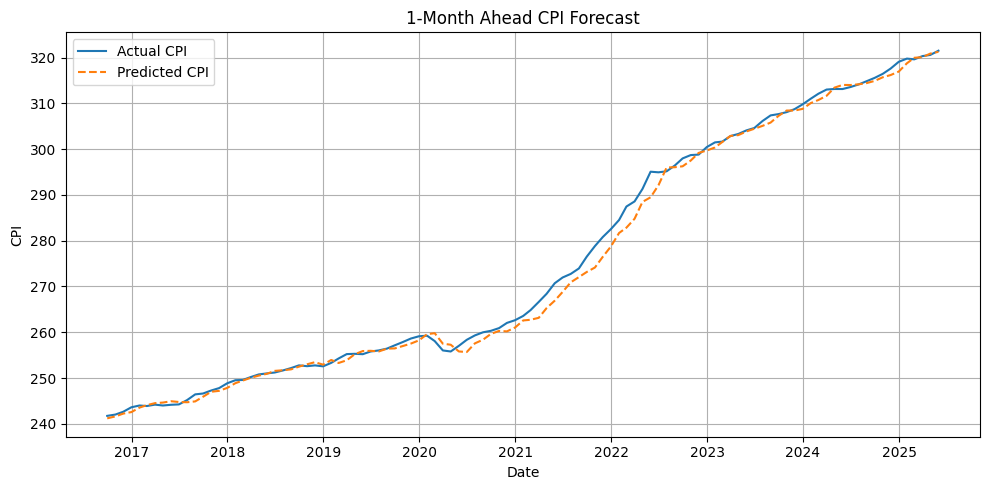

In [20]:
# Actual vs Predicted Plot ---
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual CPI')
plt.plot(y_test.index, y_pred, label='Predicted CPI', linestyle='--')
plt.title("1-Month Ahead CPI Forecast")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Ridge Regression model does a great job predicting CPI one month ahead, with a mean squared error of just 2.74 and an R² score of 0.9961, showing it captures over 99% of the actual CPI’s variation. As the chart shows, the predicted line tracks the real CPI almost perfectly, even through sharp rises like those in 2021 and 2022.

By using lagged features like the Fed Funds Rate, M2 Money Supply, and past CPI, the model captures the key drivers of inflation while Ridge regularization keeps it from overfitting. Overall, the results suggest this setup is highly effective at modeling short-term inflation trends.

C:\Users\steve\AppData\Local\Temp\ipykernel_26380\3244916252.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_26380\3244916252.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_26380\3244916252.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


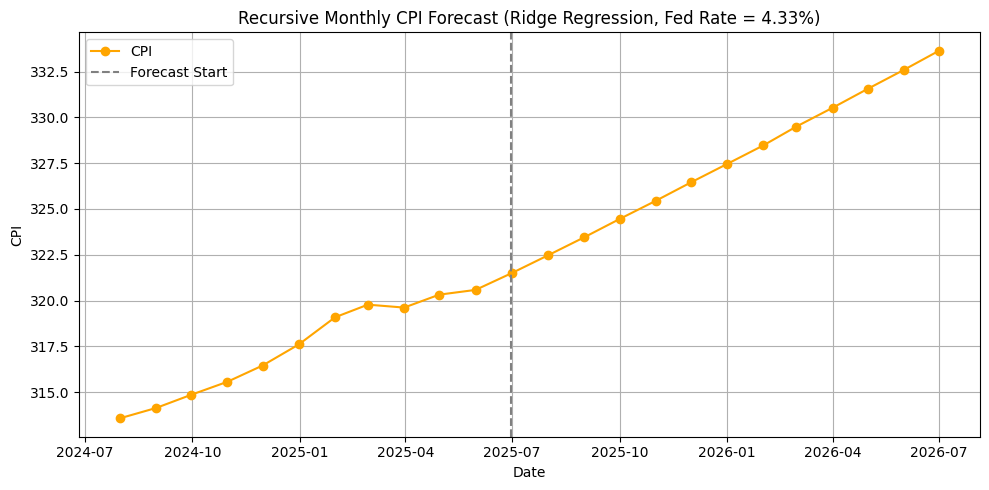


Forecast Table (Ridge Regression, Fed Rate = 4.33%)
         Date  Forecasted CPI
0  2025-07-01      321.500000
1  2025-08-01      322.471956
2  2025-09-01      323.457905
3  2025-10-01      324.449669
4  2025-11-01      325.447280
5  2025-12-01      326.450775
6  2026-01-01      327.460187
7  2026-02-01      328.475552
8  2026-03-01      329.496905
9  2026-04-01      330.524280
10 2026-05-01      331.557714
11 2026-06-01      332.597242
12 2026-07-01      333.642901


In [21]:
# --- Corrected Recursive Forecast Setup ---
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Initialize history buffers
fed_factor_history = list(data['Fed_Funds_Factor'].dropna().iloc[-7:].values)
cpi_lag1 = initial_cpi
m2_lag1 = m2

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=13, freq='MS')  # Extended to 13 months
forecast_cpi = [initial_cpi]  # Start with last known value

# ---  Forecast Logic (predict 12 future months)
for _ in range(12):  
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor_history[-1],
        'FedFundsFactor_lag1': fed_factor_history[-2],
        'FedFundsFactor_lag3': fed_factor_history[-4],
        'FedFundsFactor_lag6': fed_factor_history[-7],
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1
    }])

    input_scaled = scaler.transform(input_df)
    pred_cpi = ridge_model.predict(input_scaled)[0]
    forecast_cpi.append(pred_cpi)

    # update lag trackers
    fed_factor_history.append(fed_factor)
    cpi_lag1 = pred_cpi
    m2_lag1 = m2

# --- 9. Plot Forecast ---
combined_dates = past_cpi.index[:-1].append(forecast_dates)
combined_cpi = past_cpi.tolist()[:-1] + forecast_cpi  # drop duplicated initial value from historical

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', color='orange', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Ridge Regression, Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Forecast Table ---
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted CPI': forecast_cpi
})
print("\nForecast Table (Ridge Regression, Fed Rate = 4.33%)")
print(forecast_df)


The recursive CPI forecast using Ridge Regression shows a steady, moderate rise in consumer prices over the next 12 months, assuming a constant Fed Funds Rate of 4.33%. CPI is projected to increase from 321.50 in July 2025 to 333.64 by July 2026, reflecting persistent inflationary pressure under stable monetary conditions. Compared to Linear Regression, the Ridge model yields a smoother, slightly more conservative forecast. Although both models start at the same value, Linear Regression consistently projects higher CPI values, ending 0.49 points above Ridge by July 2026. While the absolute difference is small, it may carry weight in monetary policy or investment contexts.

This divergence likely stems from Ridge’s built-in regularization, which dampens overreaction to short-term fluctuations and mitigates the effects of multicollinearity among macroeconomic features. In contrast, Linear Regression, being more sensitive to recent inflation momentum, can slightly overfit the short term. In uncertain environments, Ridge's restraint makes it a more reliable tool. Overall, both models suggest a steady inflation trend, but Ridge Regression offers a more stable and robust outlook.

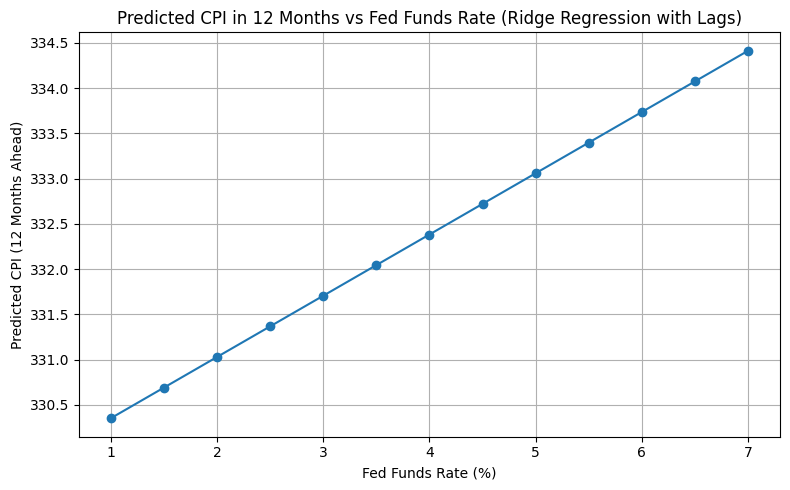

    Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)
0                  1.0                       330.351886
1                  1.5                       330.690342
2                  2.0                       331.028798
3                  2.5                       331.367254
4                  3.0                       331.705710
5                  3.5                       332.044166
6                  4.0                       332.382622
7                  4.5                       332.721078
8                  5.0                       333.059534
9                  5.5                       333.397990
10                 6.0                       333.736446
11                 6.5                       334.074902
12                 7.0                       334.413359


In [22]:
# Use same model and starting CPI as your main forecast
model = ridge_model
starting_cpi = 321.5  # June 2025 CPI (last known value)

# Other macro inputs
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Define Fed rate range for simulation
rates = np.arange(1.0, 7.1, 0.5)
forecast_horizon = 12
predicted_cpi_12mo = []

# --- Run simulation for each Fed Funds Rate ---
for rate in rates:
    fed_factor = (rate / 100) + 1
    fed_factor_history = [fed_factor] * 7  # simulate history for lags
    cpi_lag1 = starting_cpi
    m2_lag1 = m2
    forecast_cpi = [starting_cpi]  # anchor to historical CPI

    for _ in range(forecast_horizon - 1):  # already added month 0
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor_history[-1],
            'FedFundsFactor_lag1': fed_factor_history[-2],
            'FedFundsFactor_lag3': fed_factor_history[-4],
            'FedFundsFactor_lag6': fed_factor_history[-7],
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        input_scaled = scaler.transform(input_df)
        pred_cpi = model.predict(input_scaled)[0]
        forecast_cpi.append(pred_cpi)

        # update for next month
        cpi_lag1 = pred_cpi
        m2_lag1 = m2
        fed_factor_history.append(fed_factor)

    predicted_cpi_12mo.append(forecast_cpi[-1])  # take final month's CPI

# --- Plot the corrected simulation ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate (Ridge Regression with Lags)")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output forecast table ---
forecast_table = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi_12mo
})
print(forecast_table)

The Ridge Regression simulation shows a near-linear relationship between the Fed Funds Rate and predicted CPI, with higher rates slightly increasing CPI predictions. This mild slope suggests that CPI isn’t highly sensitive to rate changes in this range, likely due to the model's inclusion of lags and inflation momentum. Compared to the linear regression model, which predicts CPI based on immediate rate changes, Ridge Regression shows a gentler response, highlighting the model’s ability to account for longer-term economic factors and lagged effects.

C:\Users\steve\AppData\Local\Temp\ipykernel_26380\3672165970.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  historical_inflation = data['Inflation'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_26380\3672165970.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_inflation = data['Inflation'].dropna().last('12M')


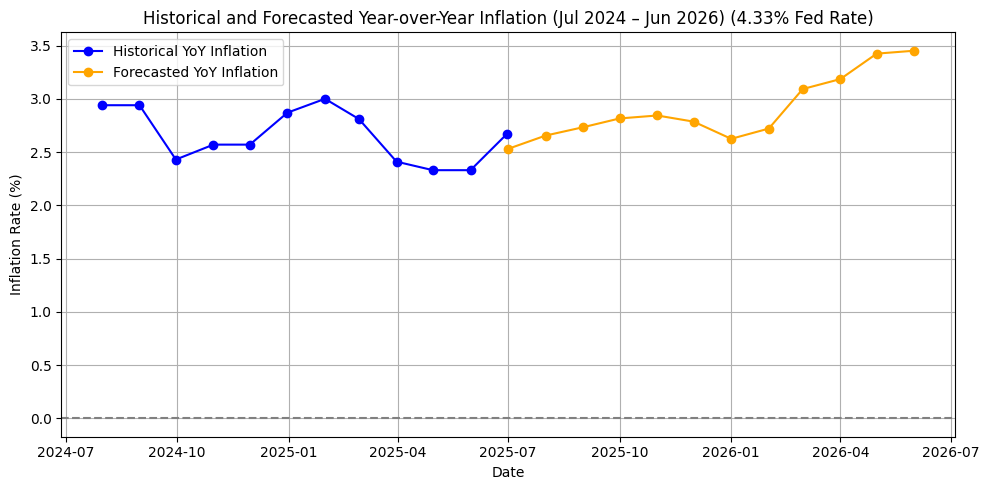

      Date  Last Year CPI  Forecasted CPI  Forecasted YoY Inflation (%)
2025-07-01        313.566      322.471956                      2.530249
2025-08-01        314.131      323.457905                      2.655248
2025-09-01        314.851      324.449669                      2.733644
2025-10-01        315.564      325.447280                      2.815806
2025-11-01        316.449      326.450775                      2.843517
2025-12-01        317.603      327.460187                      2.785797
2026-01-01        319.086      328.475552                      2.624429
2026-02-01        319.775      329.496905                      2.720836
2026-03-01        319.615      330.524280                      3.091815
2026-04-01        320.321      331.557714                      3.185330
2026-05-01        320.580      332.597242                      3.424329
2026-06-01        321.500      333.642901                      3.451708


In [23]:
# --- Inflation Calculation ---
# Year-over-year inflation is calculated by comparing the forecasted CPI with the CPI from the previous year.
# The formula used is: ((Current Year CPI - Previous Year CPI) / Previous Year CPI) * 100
# This provides the percentage change in CPI over a 12-month period, which is a standard measure of inflation.


# --- Historical Data ---
# Pull the last 12 months of actual inflation from the dataset
historical_inflation = data['Inflation'].dropna().last('12M')
historical_dates = historical_inflation.index

# --- Forecasted Data ---
last_year_cpi = [
    313.566, 314.131, 314.851, 315.564, 316.449, 317.603,
    319.086, 319.775, 319.615, 320.321, 320.580, 321.500
]

forecast_cpi = [
    321.500000, 322.471956, 323.457905, 324.449669, 325.447280,
    326.450775, 327.460187, 328.475552, 329.496905, 330.524280,
    331.557714, 332.597242, 333.642901
]

forecast_dates = pd.date_range(start='2025-07-01', periods=12, freq='MS')

forecasted_inflation = [
    ((fc - lc) / lc) * 100
    for fc, lc in zip(forecast_cpi, last_year_cpi)
]

# --- Combine for Plotting ---
all_dates = list(historical_dates) + list(forecast_dates)
all_inflation = historical_inflation.tolist() + forecasted_inflation

# --- Plot Historical + Forecasted Inflation ---
plt.figure(figsize=(10, 5))
plt.plot(historical_dates, historical_inflation, marker='o', label='Historical YoY Inflation', color='blue')
plt.plot(forecast_dates, forecasted_inflation, marker='o', label='Forecasted YoY Inflation', color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Historical and Forecasted Year-over-Year Inflation (Jul 2024 – Jun 2026) (4.33% Fed Rate)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Last Year CPI': last_year_cpi,
    'Forecasted CPI': forecast_cpi[1:],  # Skip the first month (Jul 2025) for proper YoY comparison
    'Forecasted YoY Inflation (%)': forecasted_inflation
})

# Display the forecast table
print(forecast_table.to_string(index=False))


This chart compares the historical and forecasted year-over-year (YoY) inflation from July 2024 to June 2026, assuming the Fed Funds Rate stays steady at 4.33%. It uses the most recent 12 months of actual CPI data and projects the next 12 months using a Ridge regression model that accounts for lagged macroeconomic variables. YoY inflation is calculated by comparing each forecasted month’s CPI to the same month a year earlier.

The chart shows inflation fluctuating in the historical period, ranging between 2.3% and 3.45%, followed by a gradual upward trend in the forecast. Predicted inflation starts at 2.53% in July 2025 and climbs to around 3.45% by June 2026. This rise reflects the lingering effects of prior economic conditions, with inflation showing steady momentum despite unchanged policy rates. The table below the chart gives a month-by-month breakdown of forecasted CPI and corresponding inflation, offering a clear view of where inflation may be headed over the next year.

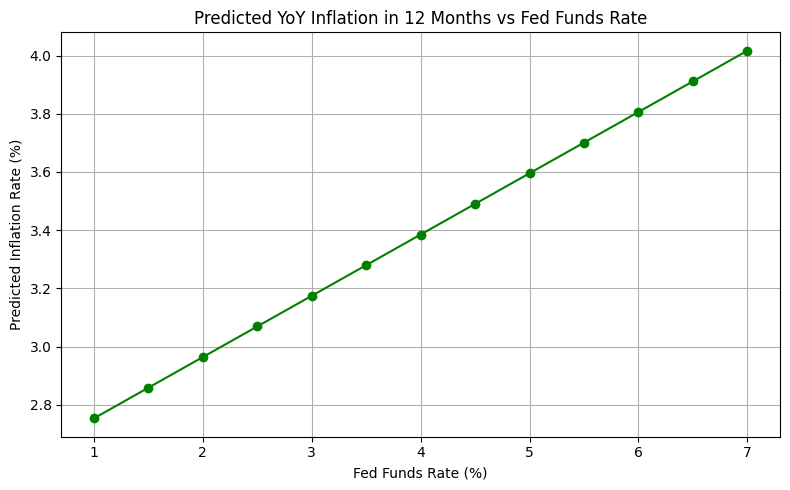

 Fed Funds Rate (%)  Predicted CPI (12 Months Ahead)  Predicted YoY Inflation (%)
                1.0                       330.351886                     2.753308
                1.5                       330.690342                     2.858582
                2.0                       331.028798                     2.963856
                2.5                       331.367254                     3.069130
                3.0                       331.705710                     3.174404
                3.5                       332.044166                     3.279678
                4.0                       332.382622                     3.384952
                4.5                       332.721078                     3.490226
                5.0                       333.059534                     3.595500
                5.5                       333.397990                     3.700774
                6.0                       333.736446                     3.806049
                

In [24]:
# --- Inputs ---
starting_cpi = 321.5  # June 2025 CPI
rates = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
predicted_cpi = [
    330.351886, 330.690342, 331.028798, 331.367254,
    331.705710, 332.044166, 332.382622, 332.721078,
    333.059534, 333.397990, 333.736446, 334.074902,
    334.413359
]


# --- Calculate YoY Inflation ---
predicted_inflation = [
    ((cpi - starting_cpi) / starting_cpi) * 100
    for cpi in predicted_cpi
]

# --- Create Forecast Table ---
forecast_df = pd.DataFrame({
    'Fed Funds Rate (%)': rates,
    'Predicted CPI (12 Months Ahead)': predicted_cpi,
    'Predicted YoY Inflation (%)': predicted_inflation
})

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_inflation, marker='o', color='green')
plt.title("Predicted YoY Inflation in 12 Months vs Fed Funds Rate")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted Inflation Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Table ---
print(forecast_df.to_string(index=False))

This analysis shows the predicted year-over-year (YoY) inflation 12 months from now across a range of Fed Funds Rates, from 1.0% to 7.0%. The results indicate a clear upward trend: as the Fed Funds Rate increases, the predicted inflation also rises, from approximately 2.75% at 1.0% to just over 4.0% at 7.0%. This counterintuitive result reflects the lagged effects of monetary policy, where inflation continues to climb in the near term despite rate hikes, due to momentum from past economic conditions.

The accompanying table outlines each Fed Funds Rate scenario, the projected CPI 12 months ahead, and the corresponding YoY inflation. The findings suggest that raising interest rates does not immediately reduce inflation, especially when inflationary pressures are persistent. Instead, the impact of rate hikes may take longer to materialize, reinforcing the importance of timing, expectations, and understanding the delayed transmission of policy into the real economy.

## Summary

In this analysis, we began by cleaning the CPI data and engineering lagged features to account for delayed macroeconomic effects. We then tested two models, Linear Regression and Ridge Regression, to evaluate how well each could forecast the Consumer Price Index (CPI) under different monetary conditions, particularly in response to changes in the Fed Funds Rate. We also examined the projected inflation trajectories over a 12-month horizon to assess how these forecasts align with broader interest rate policy.

Using Ridge Regression, we forecasted a gradual increase in CPI over the next year, with year-over-year inflation ranging from approximately 2.5% to 3.45%, assuming a constant Fed Funds Rate of 4.33%. Interestingly, the model predicted higher inflation as rates increased, a counterintuitive result, since interest rate hikes are traditionally used to cool inflation. This behavior likely stems from the model capturing recent macroeconomic patterns where both inflation and interest rates were rising in tandem. Recursive forecasting, along with the inclusion of lagged variables, helps explain the persistence of this upward trajectory.

When comparing the two models, both predicted a steady rise in CPI, but with subtle differences. Ridge Regression produced smoother and more conservative forecasts, while Linear Regression offered slightly higher, more reactive projections from month to month. For instance, by July 2026, Linear Regression projected a CPI of 334.13, whereas Ridge Regression estimated 333.64, a modest gap, but one that could carry implications for monetary policy or investment decisions. This divergence highlights the effect of Ridge’s regularization, which tempers overfitting and short-term volatility, making it more robust in uncertain environments.

Ultimately, both models revealed a positive relationship between the Fed Funds Rate and future CPI, meaning that higher interest rates were associated with higher forecasted inflation. While this contradicts conventional theory, it aligns with recent economic behavior in which the Fed raised rates in reaction to existing inflationary pressures. Our findings suggest that the Fed's influence on inflation is delayed, nonlinear, and influenced by past momentum, making it difficult to isolate direct cause and effect. This underscores the complexity of macroeconomic forecasting and the importance of using lag-aware, regularized models to better capture real-world dynamics.